# Sensitivity Analysis

In [1]:
import autoroot
import sympy
from typing import Callable
import jax
from jax import vmap, grad, jacfwd
import jax.numpy as jnp
from jaxtyping import Float, Array, PyTree
jax.config.update('jax_platform_name', 'cpu')

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Demo I - Scalar Function

In [2]:
SCALER = Float[Array, ""]
VECTOR = Float[Array, "D"]
MATRIX = Float[Array, "N D"]

$$
\begin{aligned}
\text{Function}: && &&
\boldsymbol{f}(s) &= s + \sin(2s)
\end{aligned}
$$

In [3]:
# define vector
f = lambda s: s + jnp.sin(2*s)

#### Define Gradient Function

We will take the derivative of the function, $f$, wrt the spatial length, $s$.
Calculate the analytical form!

In [4]:
s_analytical = sympy.symbols('s')
f_analytical = s_analytical + sympy.sin(2*s_analytical)
sympy.diff(f_analytical)

2*cos(2*s) + 1

The function was obtained via the `sympy` scheme.

$$
\begin{aligned}
\text{Gradient Function}: && &&
\partial_s\boldsymbol{f}(s) &= 2\sin(2s) 
\end{aligned}
$$

In [5]:
dfds_analytical = lambda s: 2*jnp.cos(2*s) + 1

I will also calculate the function using the `jax.grad` operator via the  `jax` library.

In [6]:
# define gradient
dfds = grad(f)

#### Create Vector

Here, we create a vector of observations.

In [7]:
s: VECTOR = jnp.linspace(-2*jnp.pi, 2*jnp.pi, 100)

#### Calculate Quantities

In [8]:
u = vmap(f)(s)
duds = vmap(dfds)(s)
duds_analytical = vmap(dfds_analytical)(s)

#### Plot Quantities

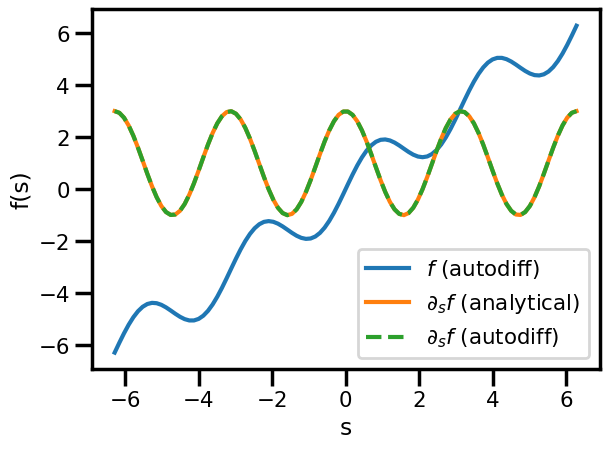

In [9]:
fig, ax = plt.subplots()

ax.plot(s, u, label="$f$ (autodiff)")
ax.plot(s, duds_analytical, label=r"$\partial_s f$ (analytical)")
ax.plot(s, duds, linestyle="--", label=r"$\partial_s f$ (autodiff)")

ax.set(
    xlabel="s",
    ylabel="f(s)",
)
plt.legend()
plt.tight_layout()
plt.show()

## Demo II - Parameterized Scalar Function

Now, we will use a slightly more complicated function whereby we let the parameter be free.
$$
\begin{aligned}
\text{Function}: && &&
\boldsymbol{f}(s;x) &= s + \sin(sx)
\end{aligned}
$$

In [10]:
# define function
def f(s, x):
    return s + jnp.sin(s*x)

In [11]:
# define parameters
x = 2.0

#### Define Gradient Function wrt s

In [12]:
# create symbols
s_analytical = sympy.symbols('s')
x_analytical = sympy.symbols('x')

# calculate function
f_analytical = s_analytical + sympy.sin(x_analytical * s_analytical)
# take derivatives
print(r"f:", f_analytical)
print(r"dfds:", sympy.diff(f_analytical, s_analytical))

f: s + sin(s*x)
dfds: x*cos(s*x) + 1


Calculate the analytical form!

$$
\begin{aligned}
\text{Gradient Function wrt s}: && &&
\partial_s\boldsymbol{f}(s;\theta) &= x\cos(sx) + 1 \\
\end{aligned}
$$

In [13]:
# define function
def dfds_analytical(s, x):
    return x * jnp.cos(s * x) + 1

Calculate the gradient

In [14]:
# define gradient
dfds = grad(f, argnums=0)

#### Create Vector

In [15]:
s: VECTOR = jnp.linspace(-2*jnp.pi, 2*jnp.pi, 100)

#### Calculate Quantities

In [16]:
u = vmap(f, in_axes=(0,None))(s, x)
duds = vmap(dfds, in_axes=(0,None))(s, x)
duds_analytical = vmap(dfds_analytical, in_axes=(0,None))(s, x)

#### Plot Quantities

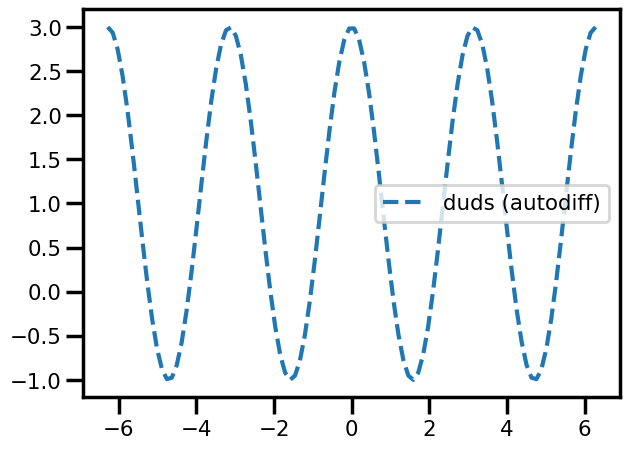

In [17]:
fig, ax = plt.subplots()

# ax.plot(s, u, label="u (autodiff)")
# ax.plot(s, duds_analytical, label="duds (analytical)")
ax.plot(s, duds, linestyle="--", label="duds (autodiff)")

plt.legend()
plt.tight_layout()
plt.show()

### Multiple Parameters

In [18]:
x = jnp.array([1.95, 2.0, 2.05, 2.25])

In [19]:
u = vmap(vmap(f, in_axes=(0,None)),in_axes=(None,0), out_axes=1)(s, x)
u.shape

(100, 4)

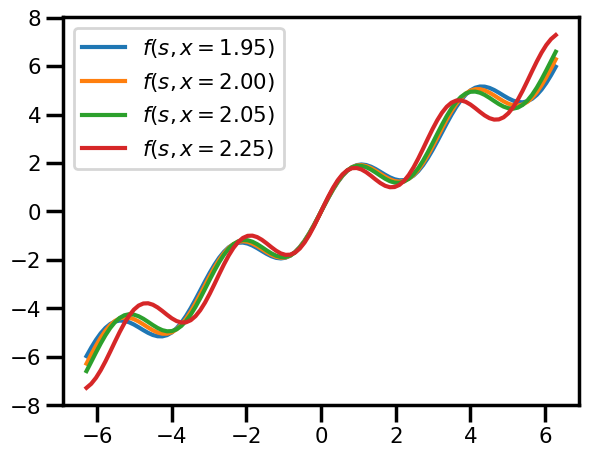

In [20]:
fig, ax = plt.subplots()

ax.plot(s, u, label="u")

plt.legend([
    f"$f(s, x={x[0]:.2f})$",
    f"$f(s, x={x[1]:.2f})$",
    f"$f(s, x={x[2]:.2f})$",
    f"$f(s,x={x[3]:.2f})$",
])
plt.tight_layout()
plt.show()

#### Gradient wrt S with multiple paramters

Now, we will do the same as before, except we will try to take the gradient wrt the coordinates, $s$, keeping in mind the different parameters, $x$.

$$
\mathbf{x} \in \mathbb{R}^N
$$


In [21]:
duds = vmap(vmap(dfds, in_axes=(0,None)),in_axes=(None,0), out_axes=1)(s, x)
assert duds.shape == (len(s), len(x))

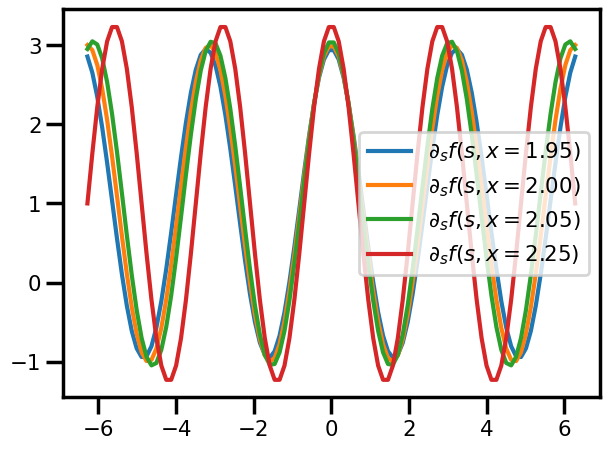

<Figure size 640x480 with 0 Axes>

In [22]:
fig, ax = plt.subplots()

ax.plot(s, duds, label=r"$\partial_s f$ ")

plt.legend([
    f"$\partial_s f(s, x={x[0]:.2f})$",
    f"$\partial_s f(s, x={x[1]:.2f})$",
    f"$\partial_s f(s, x={x[2]:.2f})$",
    f"$\partial_s f(s,x={x[3]:.2f})$",
])
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

We see that there are many *plausible* trajectories that we could fit.

### Gradient wrt parameters

Now, instead of taking the derivative wrt the input coordinates $s$, we will take the derivative wrt the input parameters $x$.

In [23]:
print(r"dfdx:", sympy.diff(f_analytical, x_analytical))

dfdx: s*cos(s*x)


$$
\begin{aligned}
\text{Gradient Function wrt x}: && &&
\partial_x\boldsymbol{f}(s;x) &= s\cos(sx) \\
\end{aligned}
$$

In [24]:
# define function
def dfdx_analytical(s, x):
    return s*jnp.cos(s*x)

In [25]:
# define gradient
dfdx = lambda s, x: grad(f, argnums=1)(s, x)

In [53]:
s = jnp.linspace(-2*jnp.pi, 2*jnp.pi, 1000)

In [54]:
# u = vmap(f, in_axes=(0,None))(s, x)
dudx = vmap(vmap(dfdx, in_axes=(0,None)),in_axes=(None,0), out_axes=1)(s, x)
dudx_analytical = vmap(vmap(dfdx_analytical, in_axes=(0,None)),in_axes=(None,0), out_axes=1)(s, x)

#### Plot Quantities

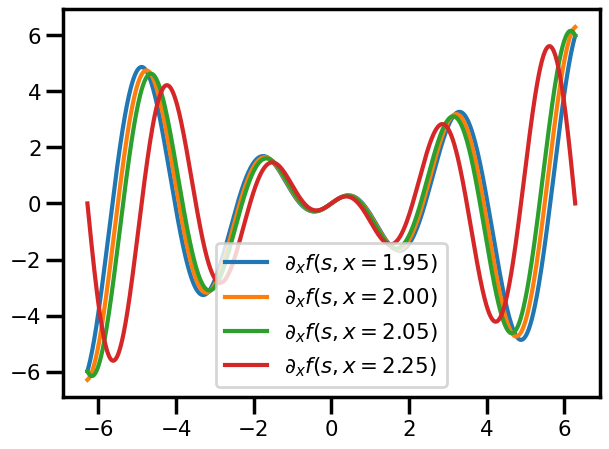

In [55]:
fig, ax = plt.subplots()

# ax.plot(s, u, label="u (autodiff)")
# ax.plot(s, dudx_analytical, label="duds (analytical)")
ax.plot(s, dudx, linestyle="-", label="duds (autodiff)")

plt.legend([
    f"$\partial_x f(s, x={x[0]:.2f})$",
    f"$\partial_x f(s, x={x[1]:.2f})$",
    f"$\partial_x f(s, x={x[2]:.2f})$",
    f"$\partial_x f(s,x={x[3]:.2f})$",
])
plt.tight_layout()
plt.show()

## Sensitivity Analysis

$$
\begin{aligned}
\text{Sample Parameter}: && &&
x_n &\sim p(x) \\
\text{Derivative Function}: && &&
\partial_x f(s,x_n) &= s\cos(sx_n) 
\end{aligned}
$$

In [28]:
import jax.random as jr

#### Uniform Distribution


$$
x_n \sim \mathcal{U}
$$

In [67]:
rng_key = jax.random.PRNGKey(123)
rng_key, rng_key_norm = jax.random.split(rng_key, 2)

num_samples = 25

x_norm = jr.uniform(key=rng_key_norm, shape=(num_samples,), minval=1.80, maxval=2.20)
x_norm = jnp.sort(x_norm)

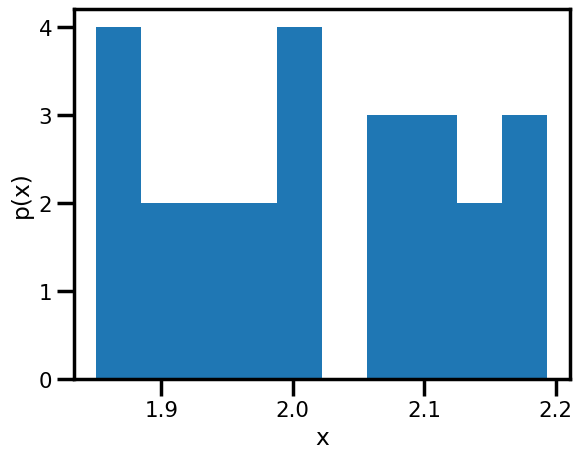

In [68]:
fig, ax = plt.subplots()

ax.hist(x_norm, bins=10)
ax.set(
    xlabel="x", ylabel="p(x)"
)
plt.show()

In [69]:
sa_results = {}

In [70]:
sa_results["uniform"] = vmap(vmap(dfdx, in_axes=(0,None)),in_axes=(None,0), out_axes=1)(s, x_norm)


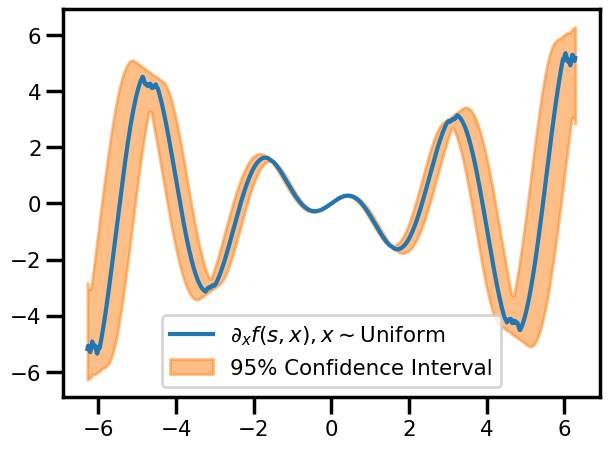

In [71]:
fig, ax = plt.subplots()

# mean & standard deviation
sa_x = jnp.quantile(sa_results["uniform"], q=jnp.asarray([0.025, 0.5, 0.975]), axis=1)

# ax.plot(s, u, label="u (autodiff)")
# ax.plot(s, dudx_analytical, label="duds (analytical)")
ax.plot(s, sa_x[1], linestyle="-", label=r"$\partial_x f(s,x), x\sim$Uniform")
ax.fill_between(
    s, sa_x[0], sa_x[2], 
    color="tab:orange", alpha=0.5,
    label=r"95% Confidence Interval",
    # linestyle="-", 
)

plt.legend()
plt.tight_layout()
plt.show()

#### Gaussian Distribution

In [72]:
rng_key = jax.random.PRNGKey(123)
rng_key, rng_key_norm = jax.random.split(rng_key, 2)

x_norm = 2.0 + 0.05 * jr.normal(key=rng_key_norm, shape=(num_samples,))
x_norm = jnp.sort(x_norm)

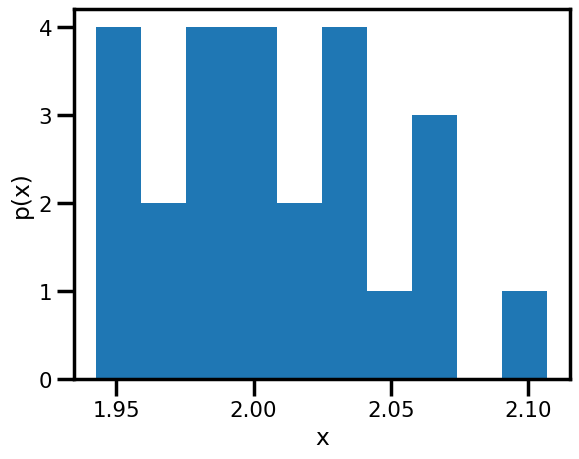

In [73]:
fig, ax = plt.subplots()

ax.hist(x_norm, bins=10)
ax.set(
    xlabel="x", ylabel="p(x)"
)
plt.show()

In [74]:
sa_results["norm"] = vmap(vmap(dfdx, in_axes=(0,None)),in_axes=(None,0), out_axes=1)(s, x_norm)


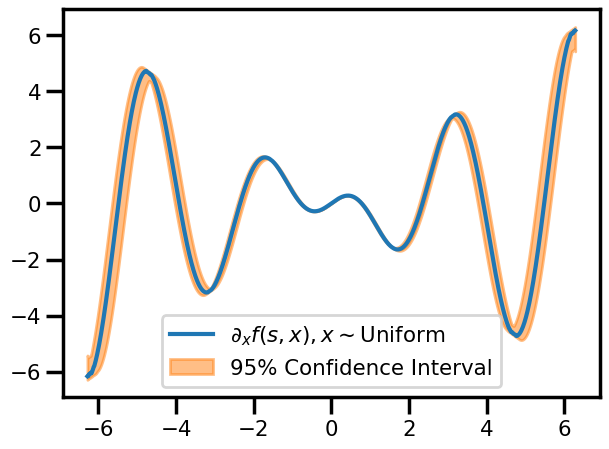

In [75]:
fig, ax = plt.subplots()

# mean & standard deviation
sa_x = jnp.quantile(sa_results["norm"], q=jnp.asarray([0.025, 0.5, 0.975]), axis=1)

# ax.plot(s, u, label="u (autodiff)")
# ax.plot(s, dudx_analytical, label="duds (analytical)")
ax.plot(s, sa_x[1], linestyle="-", label=r"$\partial_x f(s,x), x\sim$Uniform")
ax.fill_between(
    s, sa_x[0], sa_x[2], 
    color="tab:orange", alpha=0.5,
    label=r"95% Confidence Interval",
    # linestyle="-", 
)

plt.legend()
plt.tight_layout()
plt.show()

#### T-Student

In [76]:
rng_key = jax.random.PRNGKey(123)
rng_key, rng_key_norm = jax.random.split(rng_key, 2)

x_norm = 2.0 + 0.05 * jr.t(key=rng_key_norm, shape=(num_samples,), df=3.0)
x_norm = jnp.sort(x_norm)

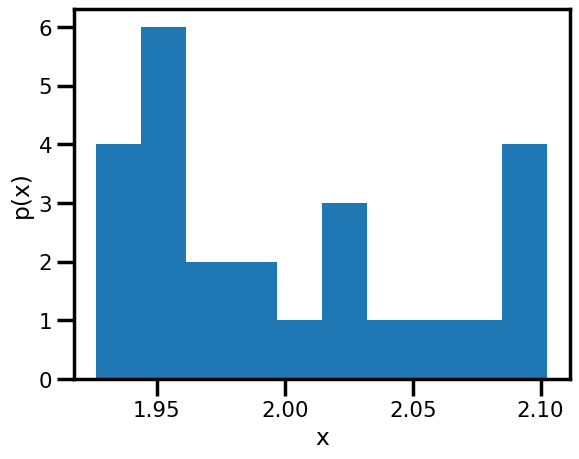

In [77]:
fig, ax = plt.subplots()

ax.hist(x_norm, bins=10)
ax.set(
    xlabel="x", ylabel="p(x)"
)
plt.show()

In [78]:
sa_results["tstudent"] = vmap(vmap(dfdx, in_axes=(0,None)),in_axes=(None,0), out_axes=1)(s, x_norm)


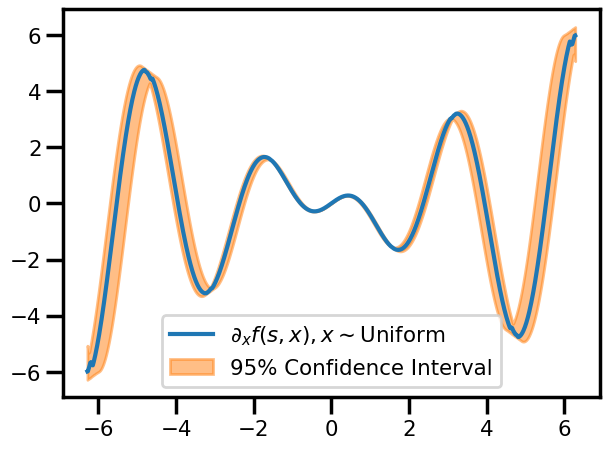

In [79]:
fig, ax = plt.subplots()

# mean & standard deviation
sa_x = jnp.quantile(sa_results["tstudent"], q=jnp.asarray([0.025, 0.5, 0.975]), axis=1)

# ax.plot(s, u, label="u (autodiff)")
# ax.plot(s, dudx_analytical, label="duds (analytical)")
ax.plot(s, sa_x[1], linestyle="-", label=r"$\partial_x f(s,x), x\sim$Uniform")
ax.fill_between(
    s, sa_x[0], sa_x[2], 
    color="tab:orange", alpha=0.5,
    label=r"95% Confidence Interval",
    # linestyle="-", 
)

plt.legend()
plt.tight_layout()
plt.show()